In [2]:
import os
import pandas as pd

DATA_PATH = '../../backend/data/database/'

In [5]:
participants_df = pd.read_parquet(os.path.join(DATA_PATH, 'participants.parquet'))
participants_df.shape

(21, 8)

In [6]:
participants_df.sample(10)

,ParticipantId,TreatmentGroup,PoliticalLeaning,Tweet1,Tweet2,Tweet3,Tweet4,ParticipantStatus
16,63a811e855cc11efbda2803f,placebo,4,R066,R085,L063,L060,finished
17,asdkaskdhjk12312312,machine,4,R042,L052,L046,R048,finished
13,63a80e0a55cc11efbda2803f,human,2,L018,L001,R019,R011,finished
0,63a8082455cc11efbda2803f,human,1,L008,R009,L006,R026,finished
3,63a80aae55cc11efbda2803f,machine,6,R062,L053,R051,L028,finished
12,63a80db055cc11efbda2803f,placebo,3,R075,L088,R082,L074,finished
4,63a80b1255cc11efbda2803f,human,7,R013,R015,L002,L017,finished
2,63a809fa55cc11efbda2803f,placebo,3,R086,R065,L059,L061,finished
11,63a80d4c55cc11efbda2803f,human,4,L016,R030,L004,R023,finished
19,TestingLoadingP,machine,4,R058,L032,L045,R038,finished


<Axes: xlabel='PoliticalLeaning'>

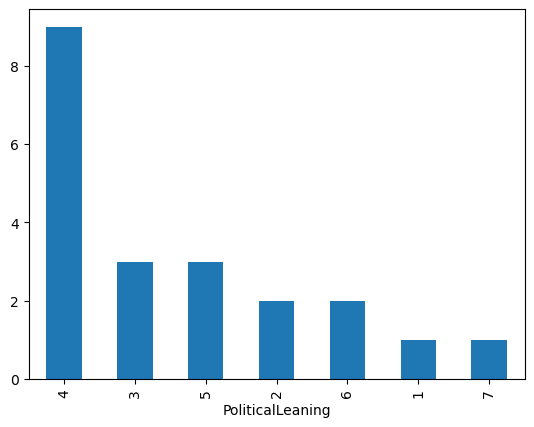

In [14]:
participants_df['PoliticalLeaning'].value_counts().plot.bar()